In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import pickle 
from scipy.interpolate import UnivariateSpline
from sklearn import linear_model

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
pi = 3.14159
data = pickle.load( open( "camera_calibration.pkl", "rb" ) )
mtx_camera = data[0]
dist_camera = data[1]

%matplotlib inline

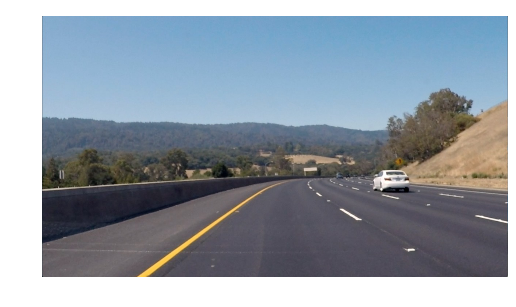

In [2]:
#reading in an image
image = mpimg.imread('test_images/test3.jpg')
#image = mpimg.imread('test_images/solidWhiteRight.jpg')

plt.imshow(image);  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image
plt.axis('off');

In [3]:
kernel_size = 5

def get_ransac_fit(all_x,all_y,model_ransac):
    all_ones = np.ones(np.shape(all_x))
    all_x_p = np.vstack((all_ones,all_x,all_x**2))
    model_ransac.fit(all_x_p.T, all_y.T)
    return model_ransac

def predict_ransac(val_y,model_ransac):
    all_ones = np.ones(np.shape(val_y))
    all_R = np.vstack((all_ones,val_y,val_y**2))
    y_ransac = model_ransac.predict(all_R.T)
    return y_ransac

def draw_pw_lines(img,pts,color):
    pts = np.int_(pts)
    for i in range(10):
        x1 = pts[0][i][0]
        y1 = pts[0][i][1]
        x2 = pts[0][i+1][0]
        y2 = pts[0][i+1][1]
        cv2.line(img, (x1, y1), (x2, y2),color,50)
        
def undistort_image(img, mtx, dist):
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    return undist_img
def gaussian_blur(img, kernel=5):
    blur = cv2.GaussianBlur(img,(kernel,kernel),0)
    return blur

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    if orient=='x':
        img_s = cv2.Sobel(img,cv2.CV_64F, 1, 0)
    else:
        img_s = cv2.Sobel(img,cv2.CV_64F, 0, 1)
    img_abs = np.absolute(img_s)
    img_sobel = np.uint8(255*img_abs/np.max(img_abs))
    
    binary_output = 0*img_sobel
    binary_output[(img_sobel >= thresh[0]) & (img_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    img_sx = cv2.Sobel(img,cv2.CV_64F, 1, 0)
    img_sy = cv2.Sobel(img,cv2.CV_64F, 0, 1)
    
    img_s = np.sqrt(img_sx**2 + img_sy**2)
    img_s = np.uint8(img_s*255/np.max(img_s))
    binary_output = 0*img_s
    binary_output[(img_s>=thresh[0]) & (img_s<=thresh[1]) ]=1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    img_sx = cv2.Sobel(img,cv2.CV_64F,1,0, ksize=sobel_kernel)
    img_sy = cv2.Sobel(img,cv2.CV_64F,0,1, ksize=sobel_kernel)
    
    grad_s = np.arctan2(np.absolute(img_sy), np.absolute(img_sx))
    
    binary_output = 0*grad_s # Remove this line
    binary_output[(grad_s>=thresh[0]) & (grad_s<=thresh[1])] = 1
    return binary_output
    
def GaussianC_Adaptive_Threshold(img,kernel,cut_val):

    img_cut = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,kernel,cut_val)
    return img_cut

def warp_image(img,src,dst,img_size):
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    Minv = cv2.getPerspectiveTransform(dst, src)

    return warped,M,Minv

def sobel_combined(image):
    img_g_mag = mag_thresh(image,3,(20,150))
    img_d_mag = dir_threshold(image,3,(.6,1.1))
    img_abs_x = abs_sobel_thresh(image,'x',5,(50,200))
    img_abs_y = abs_sobel_thresh(image,'y',5,(50,200))
    sobel_combined = np.zeros_like(img_d_mag)
    sobel_combined[((img_abs_x == 1) & (img_abs_y == 1)) | \
               ((img_g_mag == 1) & (img_d_mag == 1))] = 1
    return sobel_combined


def color_mask(hsv,low,high):
    mask = cv2.inRange(hsv, low, high)
    return mask

def apply_color_mask(hsv,img,low,high):
    mask = cv2.inRange(hsv, low, high)
    res = cv2.bitwise_and(img,img, mask= mask)
    return res

def moving_average(a, n=3):
    # Moving average
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


In [4]:
def pipeline_process(image):
    
    global left_fitx_prev   
    global right_fitx_prev
    global model_ransac_R_prev
    global model_ransac_L_prev
    
    global col_R_prev
    global col_L_prev
    global set_prev
    
    model_ransac_R = linear_model.RANSACRegressor(linear_model.LinearRegression())
    model_ransac_L = linear_model.RANSACRegressor(linear_model.LinearRegression())

    

    
    image = undistort_image(image, mtx_camera , dist_camera )
    image = gaussian_blur(image, kernel=5)
    img_size = np.shape(image)
    
    ht_window = np.uint(img_size[0]/1.5)
    hb_window = np.uint(img_size[0])
    c_window = np.uint(img_size[1]/2)
    ctl_window = c_window - .25*np.uint(img_size[1]/2)
    ctr_window = c_window + .25*np.uint(img_size[1]/2)
    cbl_window = c_window - 1*np.uint(img_size[1]/2)
    cbr_window = c_window + 1*np.uint(img_size[1]/2)
    src = np.float32([[cbl_window,hb_window],[cbr_window,hb_window],
                      [ctr_window,ht_window],[ctl_window,ht_window]])
    dst = np.float32([[0,img_size[0]],[img_size[1],img_size[0]],
                  [img_size[1],0],[0,0]])
    warped,M_warp,Minv_warp = warp_image(image,src,dst,(img_size[1],img_size[0]))
    
    image_HSV = cv2.cvtColor(warped,cv2.COLOR_RGB2HSV)

    yellow_hsv_low  = np.array([ 0, 100, 100])
    yellow_hsv_high = np.array([ 50, 255, 255])

    white_hsv_low  = np.array([  20,   0,   180])
    white_hsv_high = np.array([ 255,  100, 255])

    
    mask_yellow = color_mask(image_HSV,yellow_hsv_low,yellow_hsv_high)
    mask_white = color_mask(image_HSV,white_hsv_low,white_hsv_high)
    mask_lane = cv2.bitwise_or(mask_yellow,mask_white) 
    
    image_HLS = cv2.cvtColor(warped,cv2.COLOR_RGB2HLS)

    img_gs = image_HLS[:,:,1]
    img_abs_x = abs_sobel_thresh(img_gs,'x',5,(50,225))
    img_abs_y = abs_sobel_thresh(img_gs,'y',5,(50,225))
    wraped2 = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))
    
    img_gs = image_HLS[:,:,2]
    img_abs_x = abs_sobel_thresh(img_gs,'x',5,(50,255))
    img_abs_y = abs_sobel_thresh(img_gs,'y',5,(50,255))
    wraped3 = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))
    
    image_cmb = cv2.bitwise_or(wraped2,wraped3)
    image_cmb = gaussian_blur(image_cmb,25)
    
    image_cmb1 = np.zeros_like(image_cmb)
    image_cmb1[(mask_lane>=.5)|(image_cmb>=.5)]=1
    image_cmb1 = gaussian_blur(image_cmb1,5)
    mov_filtsize = img_size[1]/50.
    mean_lane = np.mean(image_cmb1,axis=0)
    mean_lane = moving_average(mean_lane,mov_filtsize)
        

    right_y = np.arange(11)*img_size[0]/10
    left_y = np.arange(11)*img_size[0]/10
    
    col_R = (255,255,255)
    col_L = (255,255,255)
    arg_fsb = np.argwhere(mean_lane>.025)
    
    arg_fsb_L = arg_fsb[arg_fsb<img_size[1]/2.]
    if len(arg_fsb_L)==0:
        left_fitx = left_fitx_prev
        col_L = col_L_prev
    else:
        arg_fsb_L_min = np.min(arg_fsb_L)
        arg_fsb_L_max = np.max(arg_fsb_L)
        
        img_L = np.copy(image_cmb1)
        img_L[:,0:arg_fsb_L_min] = 0
        img_L[:,arg_fsb_L_max:img_size[1]] = 0
        img_L = gaussian_blur(img_L,25)
    
        vals = np.argwhere(img_L>.5)
        if len(vals)==0:
            left_fitx = left_fitx_prev
            col_L = col_L_prev
        else:
            all_x = vals.T[0]
            all_y =vals.T[1]
            #left_fit = np.polyfit(all_x, all_y, 2)
            model_ransac_L = get_ransac_fit(all_x,all_y,
                                            model_ransac_L)
            left_fit = model_ransac_L.estimator_.coef_
            left_fitx = predict_ransac(left_y,model_ransac_L)   

            if np.sum(cv2.bitwise_and(img_L,mask_yellow))>1000:
                col_L = (255,255,0)
    arg_fsb_R = arg_fsb[arg_fsb>img_size[1]/2.]
    if len(arg_fsb_R)<10:
        right_fitx = right_fitx_prev
        model_ransac_R = model_ransac_R_prev
        right_fitx = predict_ransac(right_y,model_ransac_R)  
        col_R = col_R_prev
    else:
        arg_fsb_R_min = np.min(arg_fsb_R)
        arg_fsb_R_max = np.max(arg_fsb_R)
        
        img_R = np.copy(image_cmb1)
        img_R[:,0:arg_fsb_R_min] = 0
        img_R[:,arg_fsb_R_max:img_size[1]] = 0
        img_R = gaussian_blur(img_R,25)
    
        vals = np.argwhere(img_R>.5)
        if len(vals)<10:
            right_fitx = right_fitx_prev
            model_ransac_R = model_ransac_R_prev
            right_fitx = predict_ransac(right_y,model_ransac_R)  
            col_R = col_R_prev
        else:
            all_x = vals.T[0]
            all_y =vals.T[1]
            #right_fit = np.polyfit(all_x, all_y, 2)
            model_ransac_R = get_ransac_fit(all_x,all_y,
                                            model_ransac_R)
            right_fit = model_ransac_R.estimator_.coef_
            right_fitx = predict_ransac(right_y,model_ransac_R)    
            if np.sum(cv2.bitwise_and(img_R,mask_yellow))>1000:
                col_R = (255,255,0)
            
    if set_prev == 0:
        set_prev = 1
        right_fitx_prev = right_fitx
        left_fitx_prev  = left_fitx
        model_ransac_R_prev = model_ransac_R
        model_ransac_L_prev = model_ransac_L
        
    err_p_R = np.sum((right_fitx-right_fitx_prev)**2)/np.sum(right_fitx_prev**2)
    err_p_R = np.sqrt(err_p_R)
    if err_p_R>0.05:
        right_fitx = right_fitx_prev
        model_ransac_R = model_ransac_R_prev
        right_fitx = predict_ransac(right_y,model_ransac_R)    
        col_R = col_R_prev
    left_fitx = predict_ransac(left_y,model_ransac_L)   
    
    right_fitx = .1*right_fitx+.9*right_fitx_prev
    left_fitx =  .1* left_fitx+.9* left_fitx_prev
    
        
    #right_fitx = right_fit[0]*right_y**2 + right_fit[1]*right_y + right_fit[2]
    #left_fitx = left_fit[0]*left_y**2 + left_fit[1]*left_y + left_fit[2]
    
    warp_zero = np.zeros_like(image_cmb1).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, left_y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, right_y])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 255))

   
    
    draw_pw_lines(color_warp,np.int_(pts_left),col_L)
    draw_pw_lines(color_warp,np.int_(pts_right),col_R)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    
    newwarp = cv2.warpPerspective(color_warp, Minv_warp, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.5, 0)
    
    #right_fit_prev = right_fit
    #left_fit_prev  = left_fit
    col_R_prev = col_R
    col_L_prev = col_L
    model_ransac_R_prev = model_ransac_R
    model_ransac_L_prev = model_ransac_L
    right_fitx_prev = right_fitx
    left_fitx_prev =  left_fitx
    
    return result
    

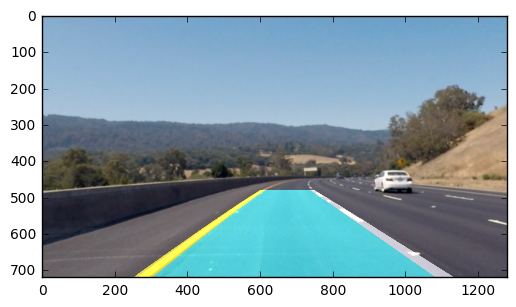

In [5]:
set_prev = 0

result_pipe = pipeline_process(image)
plt.imshow(result_pipe)

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
#left_fit_prev = np.array([0,0,0])
#right_fit_prev = np.array([0,0,0])
set_prev = 0

project_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4");
white_clip = clip1.fl_image(pipeline_process) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_output, audio=False);

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [03:59<00:00,  5.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 6min 44s, sys: 15min 35s, total: 22min 19s
Wall time: 3min 59s


In [8]:
#left_fit_prev = np.array([0,0,0])
#right_fit_prev = np.array([0,0,0])
set_prev = 0

challenge_output = 'challenge_video_output.mp4'
clip2 = VideoFileClip("challenge_video.mp4");
challenge_clip = clip2.fl_image(pipeline_process) #NOTE: this function expects color images!!
%time challenge_clip.write_videofile(challenge_output, audio=False);

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


 27%|██▋       | 133/485 [00:22<00:57,  6.10it/s]

NotFittedError: This RANSACRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [ ]:
#left_fit_prev = np.array([0,0,0])
#right_fit_prev = np.array([0,0,0])
set_prev = 0

harder_challenge_output = 'harder_challenge_video_output.mp4'
clip3 = VideoFileClip("harder_challenge_video.mp4");
harder_challenge_clip = clip3.fl_image(pipeline_process) #NOTE: this function expects color images!!
%time harder_challenge_clip.write_videofile(harder_challenge_output, audio=False);